## Student performance modeling

Bugra Duman, Kamil Matuszelański

## Outline

- Data preparation
    - Import data
    - Dummies encoding
    - Train/test split
    - Mutual information
- Linear Regression
    - Fitting one variable at a time, including variables transformations
    - Using all variables
    - Recursive feature elimination
- Feature generation 
    - testing absences variable
- Regularization - Ridge
    - Trying finding the best alpha using best 8 features from Linear Model
- Regularization - Lasso
    - Trying finding the best alpha using all features
    - Trying finding the best alpha using best 8 features from Linear Model
- KNN
- SVM
    - Finding the best c with the best features according to mutual information
    - Finding the best c with the best features according to linear model


Main takeaways:

- We have tested Linar Regression, Hurdle, Lasso, Ridge Regressions, KNN and SVM models
- We have tried feture generation using various transformations of the independent variables but none of them improved the score
- In linear regression with including all features there existed strong overfitting. We tried to eliminate that using regularization methods, Lasso and Ridge, and also by limiting number of features in the model.
- Ridge regression using smaller number of features obtained by Recursive Feature Elimination was second-best model
- Dependent variable has ~10% of score 0, and almost no observations up to score 5. This probably means that students who got score less than 5, automatically got 0 points. We tried to use hurdle model - a combination of logistic and linear regression. This did not give any improvement over other linear models.

- Apart from extensions of linear regression, we have also fitted 2 non-linear models, SVM and KNN. KNN, giving R2 twice as bad as Ridge regression, was the worst model tested. On the other hand, SVM model with R^2 score 0.1984, was the best model.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 4]

#### Import data

In [2]:
df = pd.read_csv('data/to_model.csv', index_col = 0)

In [3]:
df.head()

,age,Medu,Fedu,failures,traveltime,studytime,Dalc,Walc,absences,Final_grade,goout,famrel,guardian,Mjob,Fjob,sex,Pstatus,romantic
0,18,4,4,0,2,2,1,1,6,6,4,4,mother,at_home,teacher,F,A,no
1,17,1,1,0,1,2,1,1,4,6,3,5,father,at_home,other,F,T,no
2,15,1,1,3,1,2,2,3,10,10,2,4,mother,at_home,other,F,T,no
3,15,4,2,0,1,3,1,1,2,15,2,3,mother,health,services,F,T,yes
4,16,3,3,0,1,2,1,2,4,10,2,4,father,other,other,F,T,no


#### Dummies encoding

In [4]:
df2 = pd.get_dummies(df, drop_first = True)

#### Train/test split

We are using stratified test split with 20% of observations held out, as this is a very small dataset

In [5]:
from sklearn.model_selection import train_test_split
import random
X_train, X_test, y_train, y_test = train_test_split(df2, df2.Final_grade, test_size=0.2, random_state=10)
print(X_train.shape, X_test.shape)

(316, 25) (79, 25)


In [6]:
X_train.head()

,age,Medu,Fedu,failures,traveltime,studytime,Dalc,Walc,absences,Final_grade,...,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,sex_M,Pstatus_T,romantic_yes
266,17,3,1,0,1,2,3,4,2,10,...,0,1,0,0,1,0,0,1,1,1
352,18,1,3,1,1,1,2,3,7,8,...,0,0,0,0,0,1,0,1,1,1
97,16,2,1,0,1,2,1,1,2,10,...,1,0,0,0,1,0,0,0,1,1
167,16,4,2,0,1,2,1,1,0,16,...,0,0,0,0,0,1,0,0,1,1
280,17,4,1,0,2,1,2,4,30,8,...,0,1,0,0,1,0,0,1,0,1


#### Mutual info

First running mutual information to get intuition

In [7]:
from sklearn import feature_selection
mutual_info = feature_selection.mutual_info_classif(X_train, y_train, discrete_features=True)

In [8]:
pd.DataFrame({'minfo': mutual_info, 'col': X_train.columns}).sort_values('minfo', ascending=False).tail(-1)

,minfo,col
8,0.633463,absences
3,0.163247,failures
0,0.137014,age
1,0.133067,Medu
7,0.127030,Walc
10,0.124776,goout
2,0.100426,Fedu
5,0.097476,studytime
6,0.096018,Dalc
11,0.089056,famrel


Number of absences at school and number of failures have the biggest impact on the final grade. Later, parents education and weekly alcohol consumption play a role. 

## Modeling

### Linear regression

#### First model - LR with 1 best variable according to mutual info

In [9]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

In [10]:
cols_to_fit = [
 'absences',
]

mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[cols_to_fit]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_grade   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.121
Date:                Wed, 03 Jun 2020   Prob (F-statistic):              0.291
Time:                        13:51:28   Log-Likelihood:                -936.00
No. Observations:                 316   AIC:                             1876.
Df Residuals:                     314   BIC:                             1884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1411      0.338     30.033      0.000       9.477      10.805
absences       0.0396      0.037      1.059      0.291      -0.034       0.113
==============================================================================
Omnibus:                       21.388   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.232
Skew:                          -0.677   Prob(JB):                     5.47e-06
Kurtosis:                       3.072   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
mod = LinearRegression()
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.003557243621859052 R2 test:  -0.02281180212421563

RMSE train: 21.893829945021977 RMSE test:  17.123780476966964

MAE train: 3.5682077094611055 MAE test:  3.0299557297061965


Performance on test set is very poor - R2 is negative

At first we have tried to run model only on the best variable according to mutual information, that is number of absences at school. Performance with R2 = 0.004 is mediocre. Absences variable is not significant. Probably because it's nonlinear?

#### LR with all variables

In [14]:
all_cols = list(X_train.drop('Final_grade', axis = 1).columns)

In [15]:
cols_to_fit = all_cols
mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[cols_to_fit]))
res = mod.fit()
# res.summary()

In [16]:
mod = LinearRegression()
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.24458652935703795 R2 test:  0.0660277149203996

RMSE train: 16.59793696985791 RMSE test:  15.636440983628768

MAE train: 3.177234569559947 MAE test:  3.056795196376448


In second attempt we have included every variable avaliable to modeling. Performance got better, with R2 on train set = 0.245. However R2 on test setis 0.06 - very low.

#### LR with one variable at the time

As a mean of further gaining intuition about the best features, we are now fitting a model with only one variable at a time. This would give similar information as mutual info, but this time we are checking how particular variable is linearly dependent with the target.

In [17]:
cols_to_fit = all_cols

r2 = []

for col in cols_to_fit:
    mod = LinearRegression()
    mod.fit(X_train[cols_to_fit], y_train)
#     print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
#           'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
    
    mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [18]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
3,failures,0.127893
1,Medu,0.047465
2,Fedu,0.028789
9,goout,0.025503
0,age,0.023633


Failures is the best one - 3 times as good as the second one.

Now trying the same thing as above with testing one variable at a time, but using first squared variables, and then square rooted (an attempt to capture nonlinearity)

In [19]:
cols_to_fit = all_cols
r2 = []

for col in cols_to_fit:
    mod = sm.OLS(X_train['Final_grade'], add_constant(np.power(X_train, 2)[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [20]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
3,failures,0.105651
1,Medu,0.054122
2,Fedu,0.029472
9,goout,0.028201
0,age,0.023112


Nothing changed here - top 5 predictors are still the same. Now trying square roots.

In [21]:
r2 = []

for col in cols_to_fit:
    mod = sm.OLS(X_train['Final_grade'], add_constant(np.power(X_train, 1/2)[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [22]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
3,failures,0.126626
1,Medu,0.035716
2,Fedu,0.024323
0,age,0.023833
8,absences,0.023581


In [23]:
r2_vals = []
rmse_vals = []
mae_vals = []
for col in cols_to_fit:
    col = [col]
    mod = LinearRegression()
    mod.fit(X_train[col], y_train)
    
    # R2
    r2_train = r2_score(y_train, mod.predict(X_train[col]))
    r2_test = r2_score(y_test, mod.predict(X_test[col]))
    r2_vals.append((col[0], r2_train, r2_test))
    
    # RMSE
    rmse_train = mean_squared_error(y_train, mod.predict(X_train[col]))
    rmse_test = mean_squared_error(y_test, mod.predict(X_test[col]))
    rmse_vals.append((col[0], rmse_train, rmse_test))

    # MAE
    mae_train = mean_absolute_error(y_train,mod.predict(X_train[col]))
    mae_test = mean_absolute_error(y_test,mod.predict(X_test[col]))
    mae_vals.append((col[0], mae_train,mae_test))
    # print((rmse_train, rmse_test,mae_test))
    
one_lr_r2_df = pd.DataFrame(r2_vals, columns = ['col', 'train', 'test'])
one_lr_rmse_df = pd.DataFrame(rmse_vals, columns = ['col', 'train', 'test'])
one_lr_mae_df = pd.DataFrame(mae_vals,columns=['col', 'train','test'])

In [24]:
one_lr_rmse_df.sort_values('test').head()

,col,train,test
3,failures,19.161925,14.451807
1,Medu,20.929084,16.051731
0,age,21.452719,16.145578
13,Mjob_health,21.763047,16.234772
23,romantic_yes,21.668148,16.266399


Best features are failures and, after that Medu and age.

#### Recursive feature elimination from LR

In [25]:
from sklearn.feature_selection import RFE, RFECV

In [26]:
cols_to_fit = all_cols
rfe = RFE(mod, n_features_to_select = 1)
rfe.fit(X_train[cols_to_fit], y_train)
rfe.ranking_
pd.DataFrame({'col': cols_to_fit, 'rank': rfe.ranking_}).sort_values('rank').head(5)

,col,rank
3,failures,1
13,Mjob_health,2
15,Mjob_services,3
18,Fjob_other,4
19,Fjob_services,5


Failures is again ranked as the best, while importance of student's parents is visible now.

Now adding prediction on test set for gradually increasing number of parameters

In [27]:
rankings = pd.DataFrame({'col': cols_to_fit, 'rank': rfe.ranking_}).sort_values('rank')

r2_vals = []
rmse_vals = []
mae_vals = []

for i in range(1, len(rankings)):
#     pass
    features = list(rankings.iloc[:i,0])
#     print(f'fitting for {i}')
    mod = LinearRegression()
    mod.fit(X_train[features], y_train)
    
    # R2
    r2_train = r2_score(y_train, mod.predict(X_train[features]))
    r2_test = r2_score(y_test, mod.predict(X_test[features]))
    r2_vals.append((r2_train, r2_test))
    
    # RMSE
    rmse_train = mean_squared_error(y_train, mod.predict(X_train[features]))
    rmse_test = mean_squared_error(y_test, mod.predict(X_test[features]))
    rmse_vals.append((rmse_train, rmse_test))

    # MAE
    mae_train = mean_absolute_error(y_train,mod.predict(X_train[features]))
    mae_test = mean_absolute_error(y_test,mod.predict(X_test[features]))
    mae_vals.append((mae_train,mae_test))
    # print((rmse_train, rmse_test,mae_test))
    
    
#     print(i)

In [28]:
rfe_r2_df = pd.DataFrame(r2_vals, columns = ['train', 'test']).reset_index()
rfe_rmse_df = pd.DataFrame(rmse_vals, columns = ['train', 'test']).reset_index()
rfe_mae_df = pd.DataFrame(mae_vals,columns=['train','test']).reset_index()

#### Plot - Comparison of R^2 for train and validation sets depending on number of features

In [29]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'RMSE')

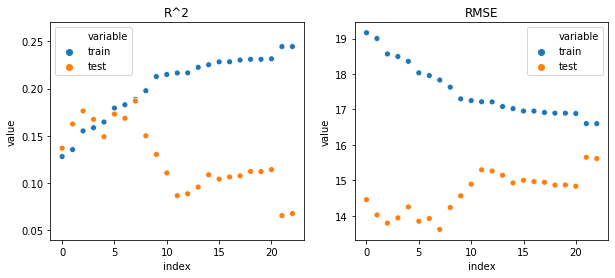

In [30]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_r2_df, id_vars = 'index')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_rmse_df, id_vars = 'index')).set_title('RMSE')

# plt.subplot(1, 3, 3)
# sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_mae_df, id_vars = 'index')).set_title('MAE')

So, about 8 first features gives similar outcome for train and test set, anythig more than than ruins validation score. An interesting observation is RMSE on train set is higher than test. 

#### LR - best variables from RFE

##### BEST

Fitting linear model with these variables

In [31]:
cols_to_fit = list(rankings.iloc[:8,0])
mod = LinearRegression()
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.18856489230781148 R2 test:  0.18676160662241792

RMSE train: 17.828843800126492 RMSE test:  13.615130070573635

MAE train: 3.2429877083643324 MAE test:  2.768752852442891


### Feature generation/selection

#### Benchmark model

Best 8 features

In [32]:
cols_to_fit = list(rankings.iloc[:8,0])

mod = LinearRegression()
res = mod.fit(add_constant(X_train[cols_to_fit]), X_train['Final_grade'])

rmse_train = mean_squared_error(y_train, mod.predict(add_constant(X_train[cols_to_fit])))
rmse_test = mean_squared_error(y_test, mod.predict(add_constant(X_test[cols_to_fit])))
print("train:", rmse_train, "test: ", rmse_test)

train: 17.828843800126492 test:  13.615130070573631


There is no absences variable. From the plot it looks promising, there is some non_linearity that LR can't account for.

Text(0.5, 1.0, 'absences')

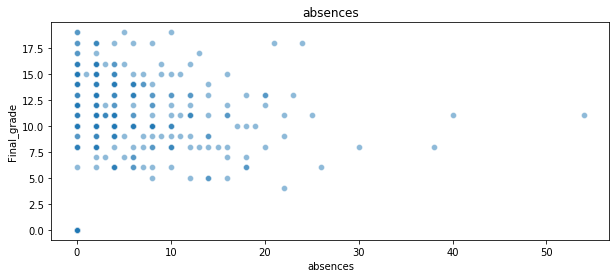

In [33]:
sns.scatterplot(x = 'absences', y = 'Final_grade', data = X_train, alpha = 0.5).set_title('absences')

#### Absences - threshold

On the above plot it looks that students with more than 20 absences have lower grade. Thus, to features from recursive feature elimination, we are adding binned absences variable with 2 bins. 

In [34]:
cols_to_fit = list(rankings.iloc[:8,0])# + ['absences']

mod = LinearRegression()
res = mod.fit(add_constant(X_train[cols_to_fit]), X_train['Final_grade'])

rmse_train = mean_squared_error(y_train, mod.predict(add_constant(X_train[cols_to_fit])))
rmse_test = mean_squared_error(y_test, mod.predict(add_constant(X_test[cols_to_fit])))
print("train:", rmse_train, "test: ", rmse_test)

train: 17.828843800126492 test:  13.615130070573631


In [35]:
scores = []
for threshold in range(10, 50):
#     print('Threshold: ', threshold)
    abs_temp = X_train.copy()
    abs_temp['thr'] = abs_temp.absences>threshold

    abs_temp_test = X_test.copy()
    abs_temp_test['thr'] = abs_temp_test.absences>threshold

    cols_to_fit = list(rankings.iloc[:8,0]) + ['thr']

    mod = LinearRegression()
    res = mod.fit(add_constant(abs_temp[cols_to_fit]), X_train['Final_grade'])

    rmse_train = mean_squared_error(y_train, mod.predict(add_constant(abs_temp[cols_to_fit])))
    rmse_test = mean_squared_error(y_test, mod.predict(add_constant(abs_temp_test[cols_to_fit])))
    scores.append((threshold, rmse_train, rmse_test))
#     print("train:", rmse_train, "test: ", rmse_test)

Text(0.5, 1.0, 'RMSE')

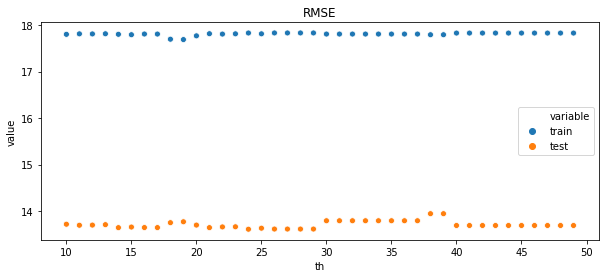

In [36]:
a = pd.DataFrame(scores, columns = ['th', 'train', 'test'])
sns.scatterplot(x = 'th', y= 'value', hue = 'variable', data = pd.melt(a, id_vars = 'th')).set_title('RMSE')

Some small bumps in RMSE is probably due specific observations influence, and not actual relationship. Above 30 absences there are only 5 students.

#### Absences - roots

We have tried non-linear transformations of absences variable. The best score was obtained using root of order 20 - below plot of transformed variable is presented. Again, this transformation did not improve the score.

In [37]:
scores = []
for threshold in range(10, 11):
#     print('Threshold: ', threshold)
    abs_temp = X_train.copy()
    abs_temp['thr'] = abs_temp.absences**(1/20)

    abs_temp_test = X_test.copy()
    abs_temp_test['thr'] = abs_temp_test.absences**(1/20)

    cols_to_fit = list(rankings.iloc[:8,0]) + ['thr']

    mod = LinearRegression()
    res = mod.fit(add_constant(abs_temp[cols_to_fit]), X_train['Final_grade'])

    rmse_train = mean_squared_error(y_train, mod.predict(add_constant(abs_temp[cols_to_fit])))
    rmse_test = mean_squared_error(y_test, mod.predict(add_constant(abs_temp_test[cols_to_fit])))
    scores.append((threshold, rmse_train, rmse_test))
    print("train:", rmse_train, "test: ", rmse_test)

train: 16.387996747776533 test:  13.347514671257512


Text(0.5, 1.0, 'absences')

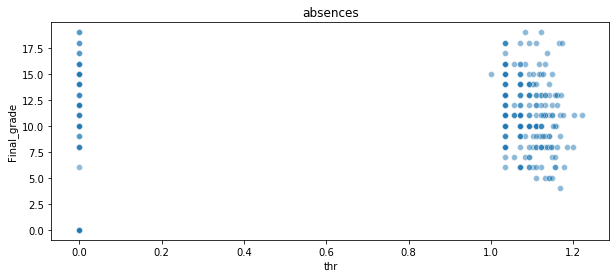

In [38]:
sns.scatterplot(x = 'thr', y = 'Final_grade', data = abs_temp, alpha = 0.5).set_title('absences')

### Ridge Regression

We are using best 8 features obtained from linear regression. We have also tried to test Ridge with all features, but performance was way lower.

In [39]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(0,10000))
alphas = np.linspace(0.1,30,40)

cols_to_fit = list(rankings.iloc[:8,0])
# cols_to_fit = all_cols

scores = []
scores_rmse = []
scores_mae = []

for alpha in alphas:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []

    mae_train = []
    mae_test = []
    
    for train, test in kf.split(X_train.index.values):
        
        reg = Ridge(alpha = alpha)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))

        mae_test.append(mean_absolute_error(X_train.iloc[test].Final_grade, preds))
        mae_train.append(mean_absolute_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (alpha, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)   
    
    b = (alpha, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)  

    c = (alpha,np.mean(mae_test),np.mean(mae_train)) 
    scores_mae.append(c)

In [40]:
r2_scores_ridge = pd.DataFrame(scores, columns = ['alpha', 'test', 'train'])
rmse_scores_ridge = pd.DataFrame(scores_rmse, columns = ['alpha', 'test', 'train'])
mae_scores_ridge = pd.DataFrame(scores_mae,columns = ['alpha','test','train'])

Text(0.5, 1.0, 'MAE')

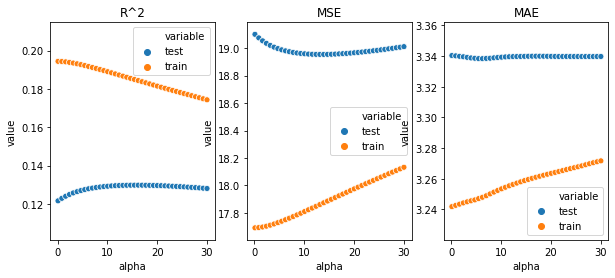

In [41]:
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(r2_scores_ridge, id_vars = 'alpha')).set_title('R^2')
plt.subplot(1, 3, 2)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_ridge, id_vars = 'alpha')).set_title('MSE')
plt.subplot(1, 3, 3)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(mae_scores_ridge, id_vars = 'alpha')).set_title('MAE')

##### BEST

Alpha ~10 is the best by RMSE - fitting that using to the full set

In [42]:
mod = Ridge(alpha = 10)
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.18488831363742242 R2 test:  0.19556222030084514

RMSE train: 17.909625548675272 RMSE test:  13.467791355495258

MAE train: 3.259580203075185 MAE test:  2.710594372447218


Performance on the test set 0.1955 was the best one obtained.

### Lasso regression

Now I'm trying to fit Lasso regression - as a mean of feature selection

In [43]:
from sklearn.linear_model import Lasso

In [44]:
cols_to_fit = all_cols

In [45]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
alphas = np.linspace(0.01, 0.5, 80)

scores = []
scores_rmse = []

for alpha in alphas:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    
    for train, test in kf.split(X_train.index.values):
        
        reg = Lasso(alpha = alpha)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (alpha, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)   
    
    b = (alpha, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)   
#     print(a)


In [46]:
r2_scores_lasso = pd.DataFrame(scores, columns = ['alpha', 'test', 'train'])
rmse_scores_lasso = pd.DataFrame(scores_rmse, columns = ['alpha', 'test', 'train'])

Text(0.5, 1.0, 'RMSE')

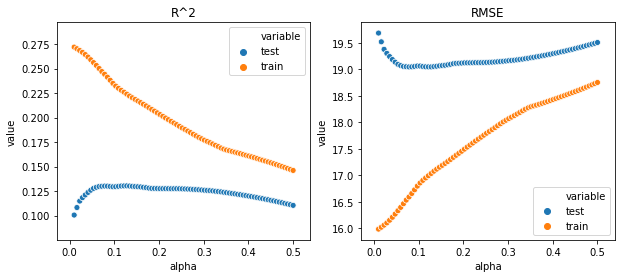

In [47]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(r2_scores_lasso, id_vars = 'alpha')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_lasso, id_vars = 'alpha')).set_title('RMSE')

Alpha around 0.1-0.2 seems correct. The score is dropping very slowly, so to obtain parsimonious model I have used alpha = 0.2

##### BEST

In [48]:
mod = Lasso(alpha = 0.2)
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.18259747623034983 R2 test:  0.10054442356484294

RMSE train: 17.959959804507935 RMSE test:  15.058566793687524

MAE train: 3.27516333080704 MAE test:  2.8607161991464856


R2 score for train dataset is very similar to the one obtained by taking best 8 features (with normal model). However performance on the test set varies significantly - ~0.18 vs 0.1

Now trying trying using the best 8 features obtained earlier. They were shown as the best ones with Ridge, so we expect similar behaviour in Lasso.

In [49]:
cols_to_fit = list(rankings.iloc[:8,0])

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
alphas = np.linspace(0.01, 0.5, 80)

scores = []
scores_rmse = []

for alpha in alphas:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    
    for train, test in kf.split(X_train.index.values):
        
        reg = Lasso(alpha = alpha)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (alpha, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)   
    
    b = (alpha, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)   
#     print(a)


In [51]:
r2_scores_lasso = pd.DataFrame(scores, columns = ['alpha', 'test', 'train'])
rmse_scores_lasso = pd.DataFrame(scores_rmse, columns = ['alpha', 'test', 'train'])

Text(0.5, 1.0, 'RMSE')

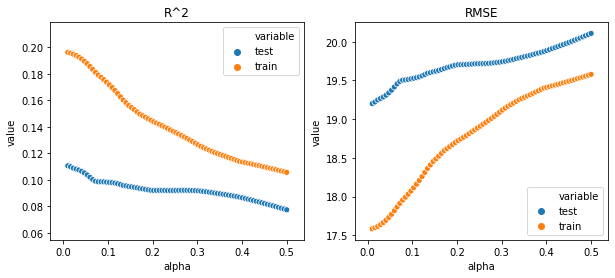

In [52]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(r2_scores_lasso, id_vars = 'alpha')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_lasso, id_vars = 'alpha')).set_title('RMSE')

According to these plots, correct alpha is 0 - which means standard linear model as was obtained earlier. To summarise, using Lasso did not bring improvement over standard linear regression. However Ridge regression improved the scores.

### Using Hurdle regression

Hurdle regression is a stack of 2 methods - linear regression and logistic reggresion. First, logistic regression is used to determine whether score should be 0 or non-zero. After that, on models predicted as non-zero, linear regression is used to determine exact score. We have used this model as 10% of our target variable equals 0.

Implementation taken from https://geoffruddock.com/building-a-hurdle-regression-estimator-in-scikit-learn/ - copied to hurdle.py file

Fitting on the 8 best features

In [53]:
from hurdle import HurdleRegression

In [54]:
cols_to_fit = list(rankings.iloc[:8,0])
mod = HurdleRegression()
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.10698105304788008 R2 test:  0.09523957581780784

RMSE train: 19.621403073186332 RMSE test:  15.147379855968683

MAE train: 3.261159288444671 MAE test:  2.8690997923629773


Adding features one by one 

In [55]:
cols_to_fit = all_cols

rankings = pd.DataFrame({'col': cols_to_fit, 'rank': rfe.ranking_}).sort_values('rank')

r2_vals = []
rmse_vals = []
mae_vals = []

for i in range(2, len(rankings)):
#     pass
    features = list(rankings.iloc[:i,0])
#     print(f'fitting for {i}')
    mod = HurdleRegression()
    mod.fit(X_train[features], y_train)
    
    # R2
    r2_train = r2_score(y_train, mod.predict(X_train[features]))
    r2_test = r2_score(y_test, mod.predict(X_test[features]))
    r2_vals.append((r2_train, r2_test))
    
    # RMSE
    rmse_train = mean_squared_error(y_train, mod.predict(X_train[features]))
    rmse_test = mean_squared_error(y_test, mod.predict(X_test[features]))
    rmse_vals.append((rmse_train, rmse_test))

    # MAE
    mae_train = mean_absolute_error(y_train,mod.predict(X_train[features]))
    mae_test = mean_absolute_error(y_test,mod.predict(X_test[features]))
    mae_vals.append((mae_train,mae_test))
    # print((rmse_train, rmse_test,mae_test))
    
    
#     print(i)

In [56]:
r2_df = pd.DataFrame(r2_vals, columns = ['train', 'test']).reset_index()
rmse_df = pd.DataFrame(rmse_vals, columns = ['train', 'test']).reset_index()
mae_df = pd.DataFrame(mae_vals,columns=['train','test']).reset_index()

Comparison of R^2 for train and validation sets depending on number of features

Text(0.5, 1.0, 'MAE')

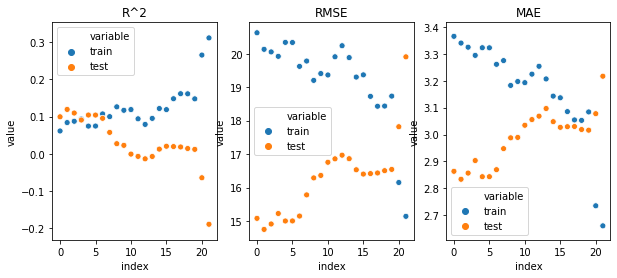

In [57]:
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(r2_df, id_vars = 'index')).set_title('R^2')

plt.subplot(1, 3, 2)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rmse_df, id_vars = 'index')).set_title('RMSE')

plt.subplot(1, 3, 3)
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(mae_df, id_vars = 'index')).set_title('MAE')

##### BEST

2 features give the best performance. Trying on full set.

In [58]:
cols_to_fit = list(rankings.iloc[:2,0])
mod = HurdleRegression()
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.061256734122922984 R2 test:  0.0993329844102725

RMSE train: 20.62605733605004 RMSE test:  15.0788485484551

MAE train: 3.365272356560191 MAE test:  2.863080730634941


### KNN

In [59]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold,cross_val_score
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
from sklearn  import metrics
from sklearn import neighbors

In [60]:
cols_to_fit = all_cols

knn = KNeighborsRegressor()
mod = knn.fit(X_train[cols_to_fit],y_train)
print("Train Score", knn.score(X_train[cols_to_fit],y_train))
print("Test Score",knn.score(X_test[cols_to_fit],y_test))

k_fold  = KFold(n_splits=10, shuffle = True ,random_state=random.randint(0,10000))
results = cross_val_score(knn, X_train[cols_to_fit], y_train, cv=k_fold)
print(results)

Train Score 0.4059064326685765
Test Score 0.1204949945447239
[ 0.35431051  0.2424918   0.11537557  0.04475961 -0.0105706  -0.36657512
 -0.06944959  0.29540599  0.03288185  0.24673118]


In [61]:
featuresCopy = cols_to_fit.copy()
kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(0,10000))
selectdFeat = []
for k in range(10):
    results = []
    for oneFeat in featuresCopy:
        tempFeatures = selectdFeat + [oneFeat]
        n_neighbors = 5
        clf = neighbors.KNeighborsRegressor(n_neighbors, n_jobs=-1, p=2)
        aucs = []
        accs = []
        for train, test in kf.split(X_train.index.values):
            clf.fit(X_train.iloc[train][tempFeatures].values, X_train.iloc[train]["Final_grade"].values)
            pred = clf.predict(X_train.iloc[test][tempFeatures].values)
            predsTrain = clf.predict(X_train.iloc[train][tempFeatures].values)
            aucs.append(metrics.r2_score(X_train.iloc[test]["Final_grade"].values,pred))
            accs.append(metrics.mean_squared_error(X_train.iloc[test]["Final_grade"].values,pred))
#         print(tempFeatures)
#         print(oneFeat, np.mean(aucs))
        results.append((np.mean(aucs), oneFeat))
    selectdFeat.append(sorted(results, key=lambda x: x[0], reverse=True)[0][1])
    featuresCopy.remove(sorted(results, key=lambda x: x[0], reverse=True)[0][1])

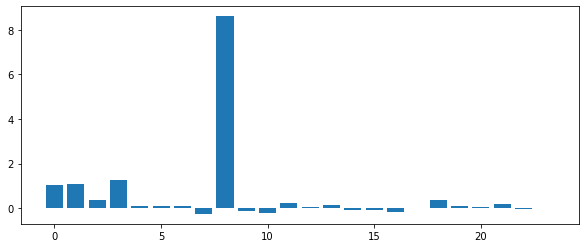

In [62]:
results = permutation_importance(knn, X_train[cols_to_fit], y_train,scoring='neg_mean_squared_error')
importance = results.importances_mean
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
#plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


In [63]:
knn_models = {}
for i in range(1, 50):
    knn_models[str(i)] = KNeighborsRegressor(n_neighbors=i);
    knn_models[str(i)].fit(X_train[cols_to_fit],y_train);
    score = knn_models[str(i)].score(X_test[cols_to_fit],y_test)
#     print("Validation score for n_neighbors = " + str(i) + " is " + str(score))

After 5 neighbors the score decreases slowly.

##### BEST

In [64]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

grid_params = {
    'n_neighbors': [3,5,7,11],
    'metric': ['euclidean','manhattan']
}

gs =GridSearchCV(knn,grid_params,verbose=1,cv=5,n_jobs=-1)

gs_results = gs.fit(X_train[cols_to_fit],y_train)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.1s finished


In [65]:
print('Best score',gs_results.best_score_)
print(gs_results.best_params_)
print(gs_results.best_estimator_)

Best score 0.1370899909838878
{'metric': 'euclidean', 'n_neighbors': 7}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')


### SVM

In [66]:
cols_to_fit = all_cols

#### SVM with features from mutual infromation

In [67]:
from sklearn.svm import SVR

As SVM is a nonlinear model, let's use the 10 best variables obtained from mutual information, rather than variables from feature selection.

In [68]:
list(pd.DataFrame({'minfo': mutual_info, 'col': X_train.columns}).sort_values('minfo', ascending=False).head(11).col)

cols_to_fit = [
    'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel'
]

In [69]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
cs = np.linspace(0.1, 30, 300)

scores = []
scores_rmse = []

for c in cs:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    for train, test in kf.split(X_train.index.values):
        
        reg = SVR(C = c)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (c, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)    
    
    b = (c, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)    
#     print(a)


In [70]:
r2_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
rmse_scores_svm = pd.DataFrame(scores_rmse, columns = ['c', 'test', 'train'])

Text(0.5, 1.0, 'RMSE')

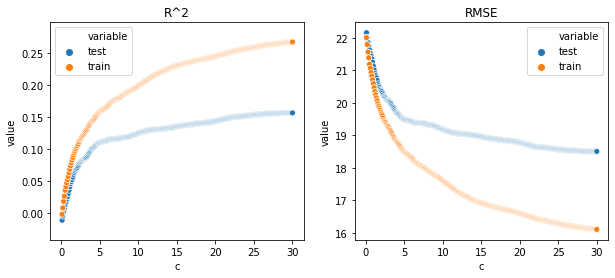

In [71]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(r2_scores_svm, id_vars = 'c')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_svm, id_vars = 'c')).set_title('RMSE')

Value of c around 12 seems ok by criterion of R2, however using RMSE best value is ~25-30 - then performance on the CV test set is the best from models tried so far

##### BEST (OF ALL)

In [72]:
mod = SVR(C = 12)
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.22695984684518222 R2 test:  0.19841658671756246

RMSE train: 16.985230255838715 RMSE test:  13.420003928894213

MAE train: 3.064373888054063 MAE test:  2.7467486899285882


This is the best model that we have obtained - with R2 = 0.1984. 

#### SVM with features from linear regression

Now trying the model on the best 8 features obtained from linear regression, which were shown to be the best ones in Linear Regression and Ridge.

In [73]:
# cols_to_fit = ['failures',
#  'Mjob_health',
#  'Mjob_services',
#  'Fjob_other',
#  'Fjob_services',
#  'sex_M',
#  'Pstatus_T',
#  'romantic_yes']

cols_to_fit = list(rankings.iloc[:8,0])

In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
cs = np.linspace(0.1, 20, 200)

scores = []
scores_rmse = []

for c in cs:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    for train, test in kf.split(X_train.index.values):
        
        reg = SVR(C = c)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (c, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)    
    
    b = (c, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)    


In [75]:
r2_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
rmse_scores_svm = pd.DataFrame(scores_rmse, columns = ['c', 'test', 'train'])

Text(0.5, 1.0, 'RMSE')

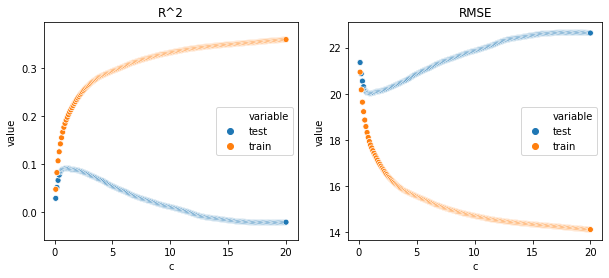

In [76]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(r2_scores_svm, id_vars = 'c')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_svm, id_vars = 'c')).set_title('RMSE')

Now it's completely different picture than in features from mutual information - c around 0.8 seems correct. However model's performance has dropped dramatically - it seems that the desicion to take best mutual info scores rather than LR scores is correct. Also, way poorer overfitting.

In [77]:
mod = SVR(C = 0.8)
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.1776459155700293 R2 test:  0.13752360094305494

RMSE train: 18.0687554441627 RMSE test:  14.43946627653645

MAE train: 3.1204081267142088 MAE test:  2.755377623633486


Performance on the test set also dropped dramatically from the mutual information features. 

#### SVM with more features

We have also tried svm with 15 instead of 10 features as before, but performance dropped.

In [78]:
cols_to_fit = list(pd.DataFrame({'minfo': mutual_info, 'col': X_train.columns}).sort_values('minfo', ascending=False).iloc[1:].head(16).col)

In [79]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
cs = np.linspace(0.1, 60, 30)

scores = []
scores_rmse = []

for c in cs:
    r2_train = []
    r2_test = []
    
    rmse_train = []
    rmse_test = []
    for train, test in kf.split(X_train.index.values):
        
        reg = SVR(C = c)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
        
        rmse_test.append(mean_squared_error(X_train.iloc[test].Final_grade, preds))
        rmse_train.append(mean_squared_error(X_train.iloc[train].Final_grade, predsTrain))
        
    a = (c, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)    
    
    b = (c, np.mean(rmse_test), np.mean(rmse_train))
    scores_rmse.append(b)    
#     print(a)


In [80]:
r2_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
rmse_scores_svm = pd.DataFrame(scores_rmse, columns = ['c', 'test', 'train'])

Text(0.5, 1.0, 'RMSE')

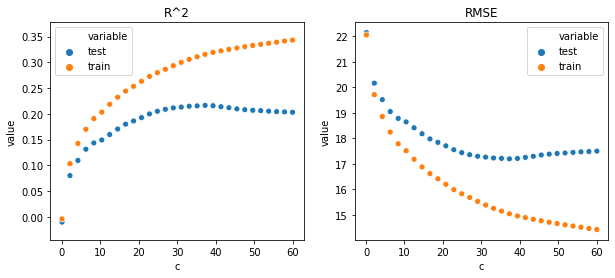

In [81]:
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(r2_scores_svm, id_vars = 'c')).set_title('R^2')

plt.subplot(1, 2, 2)
sns.scatterplot(x = 'c', y= 'value', hue = 'variable', data = pd.melt(rmse_scores_svm, id_vars = 'c')).set_title('RMSE')

In [82]:
mod = SVR(C = 30)
mod.fit(X_train[cols_to_fit], y_train)
print('R2 train:', r2_score(y_train, mod.predict(X_train[cols_to_fit])), 
      'R2 test: ', r2_score(y_test, mod.predict(X_test[cols_to_fit])))
print()
print('RMSE train:', mean_squared_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'RMSE test: ', mean_squared_error(y_test, mod.predict(X_test[cols_to_fit])))

print()
print('MAE train:', mean_absolute_error(y_train, mod.predict(X_train[cols_to_fit])), 
      'MAE test: ', mean_absolute_error(y_test, mod.predict(X_test[cols_to_fit])))

R2 train: 0.3035837528583891 R2 test:  0.1643482037861711

RMSE train: 15.301650584815578 RMSE test:  13.990372308796369

MAE train: 2.8628502617697196 MAE test:  2.85509769337845


Value of R2 for test set dropped from the model with only 8 features. 